In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from ionization import adk
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from ionization import adk
from scipy.interpolate import interp1d
from scipy.optimize import newton

path = '/mnt/md0/Data/rariniello/Filamentation/Spherical_Lens/'
lam = 0.8
tau = 35.

In [2]:
# The goal is to create a 100um diameter, 5mm long plasma in as a high a density as possible
# The maximum density possible is the critical density for the laser at 3.49e21
# If the laser is frequency doubled then the critical density is 1.40e22
# The field from a Gaussian laser beam is given by
def get_field(r, z, energy, w0):
    E0 = 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9
    k = 2*np.pi/lam
    zR = np.pi*w0**2/lam
    wz = w0*np.sqrt(1+(z[:, None]/zR)**2)
    E = E0*w0/wz*np.exp(-r[None, :]**2/wz**2)
    print(E0)
    return E
def plot_laser_plasma(I, ne, ext):
    plt.figure(figsize=(16, 4))
    plt.subplot(121)
    plt.imshow(np.flipud(np.transpose(I)), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (mm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)

    plt.subplot(122)
    plt.imshow(np.flipud(np.transpose(ne)), aspect='auto', extent=ext, cmap='plasma')
    cb = plt.colorbar()
    cb.set_label(r'$n_e$ ($\mathrm{cm^-3}$)')
    plt.xlabel('$z$ (mm)')
    plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)
    plt.tight_layout()
    plt.show()

In [3]:
# Extract length and average plasma width using full width half max
def fwhm(x, y):
    Y_half = np.amax(y)/2
    d = np.sign(Y_half - y[0:-1]) - np.sign(Y_half - y[1:])
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    return (x[right_idx] - x[left_idx])[0]

def size(z, r, ne, thresh):
    # FWHM along the length of the plasma and average FWHM for all slices above threshold
    Nz = len(z)
    Nr = len(r)
    l = 0.0
    if np.amax(ne[:, int(Nr/2)]) > thresh:
        l = fwhm(z, ne[:, int(Nr/2)])
    r_tot = 0
    n = 0
    for i in range(Nz):
        if np.amax(ne[i, :]) > thresh:
            r_tot += fwhm(r, ne[i, :])
            n += 1
    if n==0:
        w = 0
    else:
        w = r_tot/n
    return l, w

413.828733074


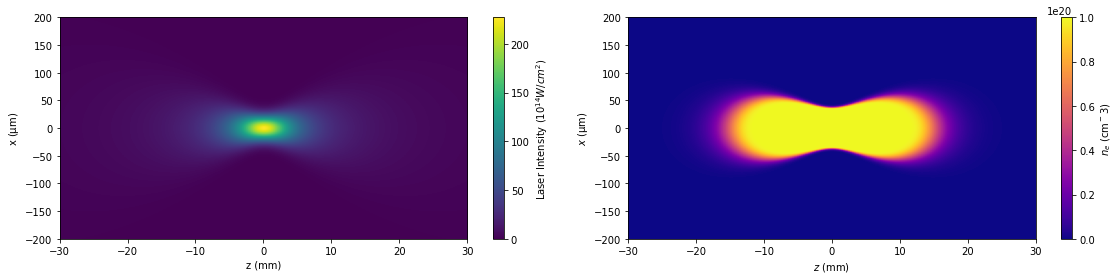

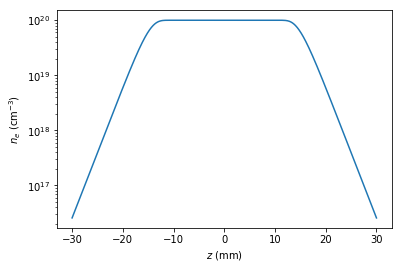

In [4]:
energy = 12e-3 #J
w0 = 31 #um
ne0 = 1e20 #cm^-3
Z = 3e4
r = np.linspace(-200, 200, 1000)
z = np.linspace(-Z, Z, 1000)
ext = [-Z/1e3, Z/1e3, -200, 200]
E = get_field(r, z, energy, w0)
I = ionization.intensity_from_field(E)
atom = ionization.He
ne = ne0*adk.gaussian_frac(atom['EI'], abs(E), tau, atom['Z'], atom['l'], atom['m'])
plot_laser_plasma(I, ne, ext)
size(z, r, ne, 0.95*1e18)
plt.plot(z/1e3, ne[:, 500])
plt.yscale('log')
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$n_e$ ($\mathrm{cm^{-3}}$)')
plt.show()

In [5]:
def intensity_field(energy, w0, ne0, X, Nx, Z, Nz, z0):
    z = np.linspace(0, Z, Nz)
    pulseParams = {
        'Nt' : 2**6,
        'Nx' : Nx,
        'Ny' : Nx,
        'X' : X,
        'Y' : X,
        'T' : 3*tau,
        'lam' : lam,
        'path' : path,
        'load' : False,
        'threads' : 20,
        'cyl' : True,
        'tau' : tau,
        'z0' : z0,
        'name' : 'w0=%0.0fum_energy=%0.1fmJ_ne0=%0.1f' % (w0, energy*1e3, ne0),
        'E0' : 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9,
        'waist' : w0
    }
    
    ext = [z0/1e3, (Z+z0)/1e3, -X/2, X/2]
    beam = laserbeam.GaussianLaser(pulseParams)
    beam.plot_current_intensity()
    beam.propagate(z, 1.0)
    e = np.zeros((Nz, Nx), dtype='complex128')
    for i in range(Nz):
        e[i, :] = beam.load_field(i+1)[0]

    ne = ne0*adk.gaussian_frac(ionization.He['EI'], abs(e), tau, ionization.He['Z'], ionization.He['l'])
    I = beam.intensity_from_field(e)
    return I, ne, ext

def refraction_field(energy, w0, ne0, X, Nx, Z, Nz, z0):
    z = np.linspace(0, Z, Nz)
    pulseParams = {
        'Nt' : 2**6,
        'Nx' : Nx,
        'Ny' : Nx,
        'X' : X,
        'Y' : X,
        'T' : 3*tau,
        'lam' : lam,
        'path' : path,
        'load' : False,
        'threads' : 20,
        'cyl' : True,
        'tau' : tau,
        'z0' : z0,
        'name' : 'w0=%0.0fum_energy=%0.1fmJ_ne0=%0.1f_pulse' % (w0, energy*1e3, ne0),
        'E0' : 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9,
        'waist' : w0
    }
    plasmaParams = {
        'Nx' : Nx,
        'Ny' : Nx,
        'Nz' : Nz,
        'X' : X,
        'Y' : X,
        'Z' : Z,
        'atom' : ionization.He,
        'path' : path,
        'load' : False,
        'cyl' : True,
        'name' : 'w0=%0.0fum_energy=%0.1fmJ_ne0=%0.1f_plasma' % (w0, energy*1e3, ne0),
        'n0' : ne0/1e17
    }

    ext = [z0/1e3, (Z+z0)/1e3, -X/2, X/2]
    pulse = laserpulse.GaussianPulse(pulseParams)
    helium = plasma.UniformPlasma(plasmaParams)
    interactions.pulse_plasma(pulse, helium)
    e = np.zeros((Nz, Nx), dtype='complex128')
    ne = np.zeros((Nz, Nx))
    for i in range(0, Nz-1):
        ne[i, :] = helium.load_plasma_density(i)[0]
    for i in range(Nz):
        e[i, :] = pulse.load_field(i)[0][int(pulseParams['Nt']/2), :]
    I = ionization.intensity_from_field(e)
    ne = ne*1e17
    return I, ne, ext

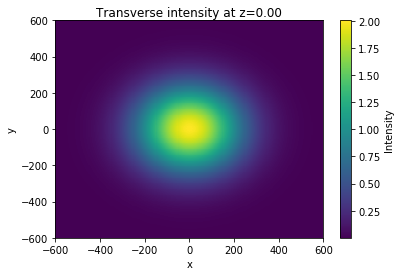

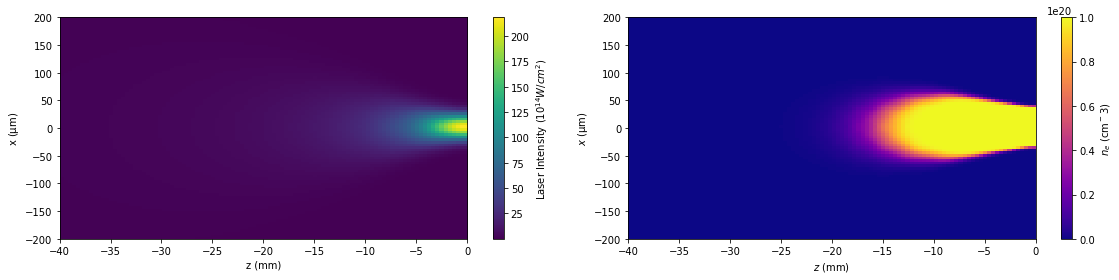

In [6]:
Nx = 2**8
X = 1200
Nz = 100
Z = 40e3
z0 = -40e3
I, ne, ext = intensity_field(12e-3, 31, 1e20, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)

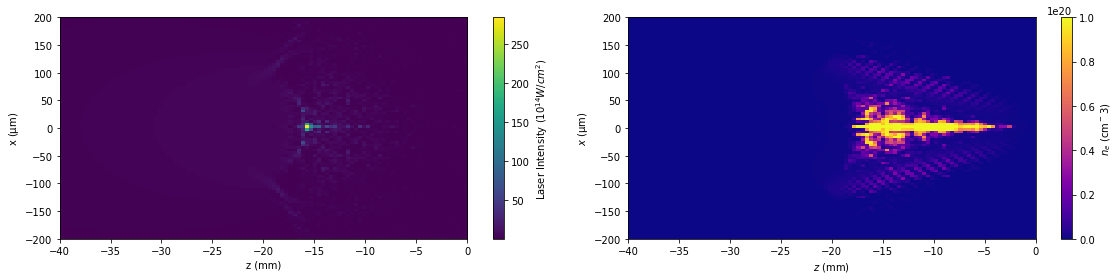

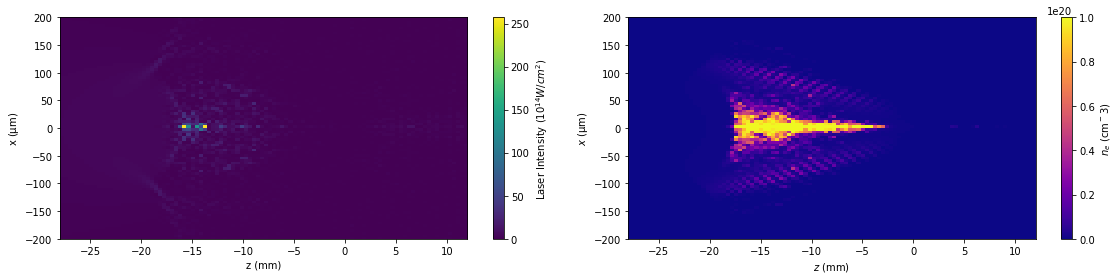

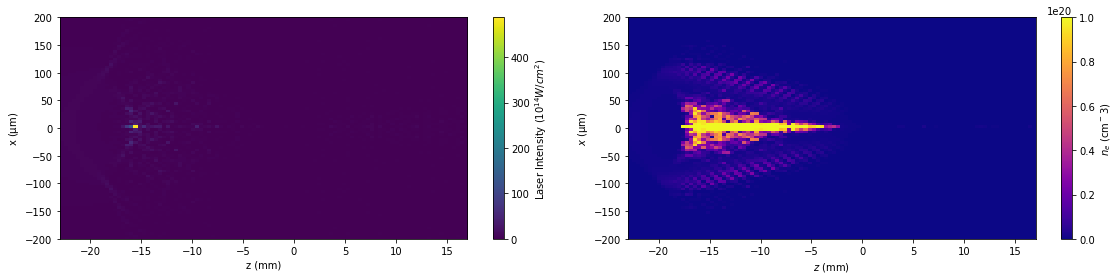

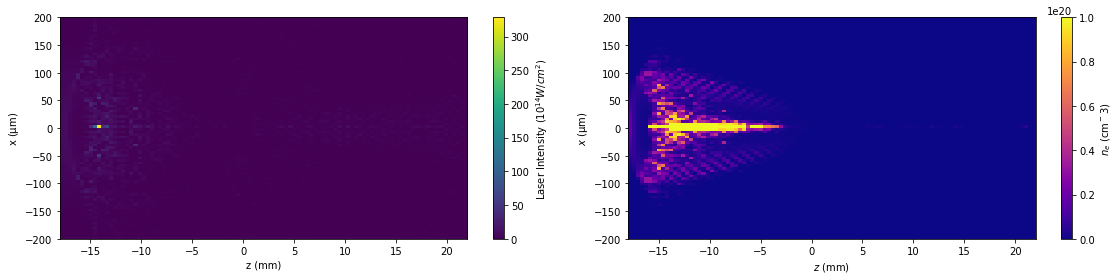

In [7]:
# Increase the amount of low density plasma and see if it effects the refraction
z0 = -40e3
I, ne, ext = refraction_field(12e-3, 31, 1e20, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)
z0 = -28e3
I, ne, ext = refraction_field(12e-3, 31, 1e20, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)
z0 = -23e3
I, ne, ext = refraction_field(12e-3, 31, 1e20, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)
z0 = -18e3
I, ne, ext = refraction_field(12e-3, 31, 1e20, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)

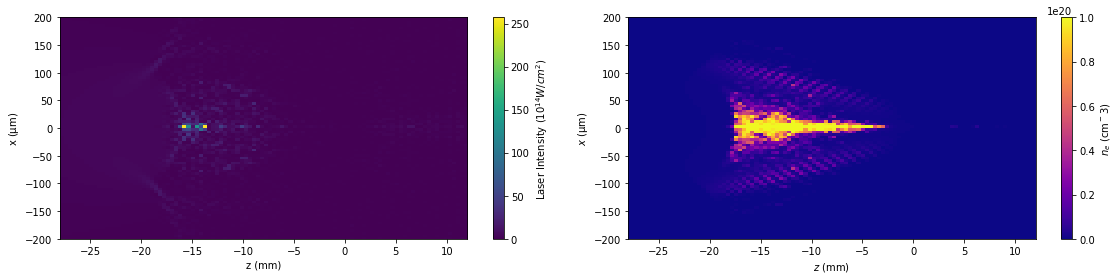

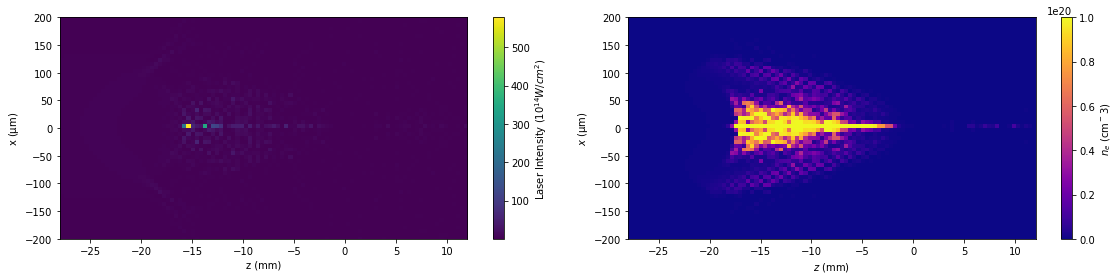

In [8]:
# Half the size of the x grid and see if there is an effect
z0 = -28e3
I, ne, ext = refraction_field(12e-3, 31, 1e20, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)
Nx = 2**7
X = 900
z0 = -28e3
I, ne, ext = refraction_field(12e-3, 31, 1e20, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)

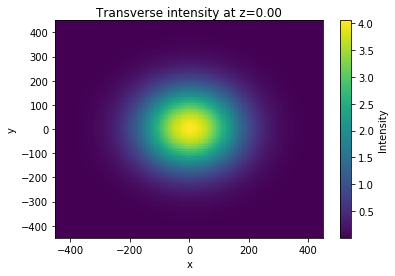

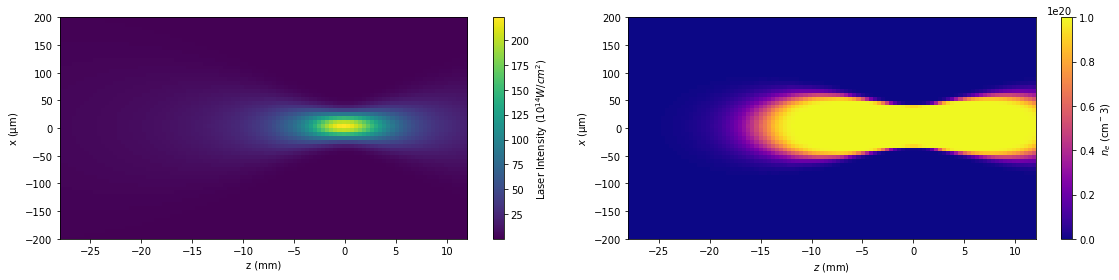

In [9]:
# Any aperture cutting off the beam is visibile in the unrefracted focus
I, ne, ext = intensity_field(12e-3, 31, 1e20, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)

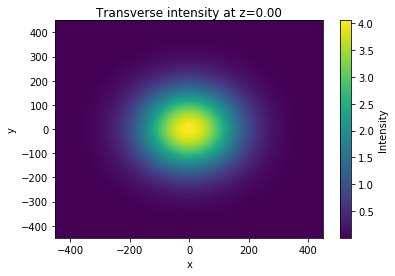

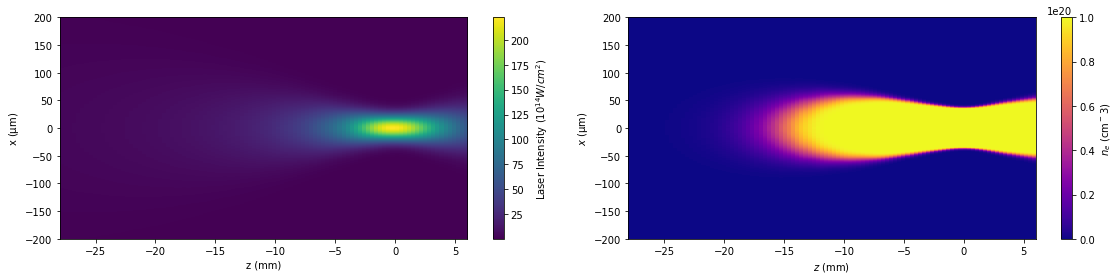

In [10]:
# These simulation parameters will take about 20s per z step
Nx = 2**11
X = 900
Nz = 100
Z = 34e3
z0 = -28e3
I, ne, ext = intensity_field(12e-3, 31, 1e20, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)

In [11]:
# Increase the dpi of the plots for these hi res sims
def plot_laser_plasma(I, ne, ext):
    plt.figure(figsize=(16, 4), dpi=300)
    plt.subplot(121)
    plt.imshow(np.flipud(np.transpose(I)), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (mm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)

    plt.subplot(122)
    plt.imshow(np.flipud(np.transpose(ne)), aspect='auto', extent=ext, cmap='plasma')
    cb = plt.colorbar()
    cb.set_label(r'$n_e$ ($\mathrm{cm^-3}$)')
    plt.xlabel('$z$ (mm)')
    plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)
    plt.tight_layout()
    plt.show()

In [ ]:
# These simulation parameters will take about 20s per z step
Nx = 2**11
X = 900
Nz = 1000
Z = 34e3
z0 = -28e3
I, ne, ext = refraction_field(12e-3, 31, 1e20, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)

In [ ]:
# These simulation parameters will take about 20s per z step
Nx = 2**11
X = 900
Nz = 1000
Z = 34e3
z0 = -28e3
I, ne, ext = refraction_field(12e-3, 31, 1e19, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)

In [ ]:
# These simulation parameters will take about 20s per z step
Nx = 2**11
X = 900
Nz = 1000
Z = 34e3
z0 = -28e3
I, ne, ext = refraction_field(12e-3, 31, 1e18, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)

In [ ]:
# These simulation parameters will take about 20s per z step
Nx = 2**11
X = 900
Nz = 1000
Z = 34e3
z0 = -28e3
I, ne, ext = refraction_field(12e-3, 31, 1e17, X, Nx, Z, Nz, z0)
plot_laser_plasma(I, ne, ext)